# Homework 1
CSE 158

Lucy Gai

Using book review data:

### 1. What is the distribution of ratings and review lengths in the dataset? Report the number of 1-, 2-, 3-star (etc.) ratings, and show the relationship with length (e.g. via a scatterplot)

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import dateutil.parser
import random
import urllib
from collections import defaultdict
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [123]:
# read in data 
f = open("fantasy_10000.json")

# list of dictionaries, each a review
data = []

for line in f:
    entry = json.loads(line)
    data.append(entry)
    
f.close()

# data[0] #is one review as a dict

In [124]:
# get distribution of ratings
ratingCounts = defaultdict(int)
ratingData = []

for entry in data:
    
    # count the number of 1-star, 2-star, etc ratings
    ratingCounts[entry['rating']] += 1

ratingCounts

defaultdict(int, {5: 3232, 4: 3265, 3: 2113, 2: 778, 1: 286, 0: 326})

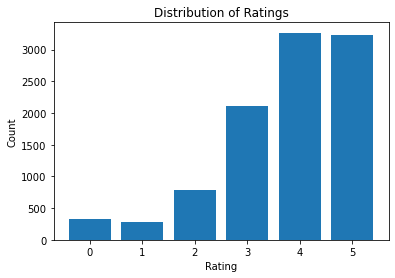

In [125]:
# plot dist. of ratings
# plt.hist(ratingData, 5)
plt.bar(ratingCounts.keys(), ratingCounts.values())
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

**The distribution of ratings is:**
- 0 star: 326 ratings
- 1 star: 286 ratings
- 2 star: 778 ratings
- 3 star: 2113 ratings
- 4 star: 3265 ratings
- 5 star: 3232 ratings

In [126]:
# get list of ratings
ratingsY = [entry['rating'] for entry in data]

# get list of review lengths
lengthsX = [len(entry['review_text']) for entry in data]

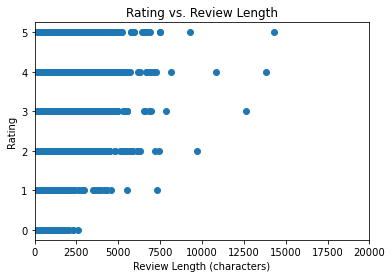

In [127]:
# plot scatterplot
plt.scatter(lengthsX, ratingsY)
plt.xlim(0, 20000)
plt.xlabel("Review Length (characters)")
plt.ylabel("Rating")
plt.title("Rating vs. Review Length")
plt.show()

The relationship of ratings with length is shown above.

### 2. Train a simple predictor that estimates rating from review length. Report the values $θ_{0}$ and $θ_{1}$, and the Mean Squared Error of your predictor (on the entire dataset).

In [128]:
def get_mse_q2(model, rating, length):
    X = np.matrix([[1,l] for l in length])
    y = np.matrix(rating).T
    
    yPred = model.predict(X)
    sse = sum([x**2 for x in (y - yPred)]) # y - y_i
    mse = sse / len(y)
    
    return mse

In [129]:
def predictor_q2(rating, length):
    X = np.matrix([[1,l] for l in length])
    y = np.matrix(rating).T

    #theta,residuals,rank,s = np.linalg.lstsq(X, y, rcond=None)
    
    # get relationship
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    model.fit(X, y)
    theta = model.coef_
    
    print("theta_0: ", theta[0][0],
          "\ntheta_1: ", theta[0][1])
    
    return model

In [130]:
model = predictor_q2(ratingsY, lengthsX)
print("\nmse: ", get_mse_q2(model, ratingsY, lengthsX))

theta_0:  3.68568135501692 
theta_1:  6.873716748962714e-05

mse:  [[1.55220866]]


#### star rating is approx: 3.685681355 + 0.000068737 * (review length in chars) 
#### The MSE of my predictor is 1.55220866

### 3. Extend your model to include (in addition to the length) features based on the time of the review. Using a one-hot encoding for the weekday and year, write down feature vectors for the first two examples.

In [131]:
# get array of years, weeks
dates = [(dateutil.parser.parse(entry['date_added'])) for entry in data]
years = [entry.year for entry in dates]
weeks = [entry.weekday() for entry in dates]


# min(years) = 2006, max(years) = 2017
# 12 years

In [132]:
# Implement One Hot Encoding
# [[week, year], [week, year]]
X = [list(a) for a in zip(weeks, years)]
enc = OneHotEncoder(drop='first')
enc.fit(X)

# 0 0 0 0 0 0 is monday (0)
# 0 0 0 0 0 1 is sunday (6)
# 11 zero's is 2006, 00000000001 is 2017
dates_enc = enc.transform(X).toarray()
dates_enc = list(list(d) for d in dates_enc)
# dates_enc[0]

In [133]:
# create feature vector
# (1, length, encodings)
def feat_enc(ind):
    vec = [1, lengthsX[ind]]
    vec.extend([d for d in dates_enc[ind]])
    return vec

#### Feature vectors for first two examples

In [134]:
feat_vects = [feat_enc(ind) for ind in range(len(data))] #list of lists

print("Feature vector for first example: ", feat_vects[0], 
     "\n Feature vector for second example: ", feat_vects[1])

Feature vector for first example:  [1, 2086, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 
 Feature vector for second example:  [1, 1521, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


### 4. Train models that use the weekday and year values directly as features and use the one-hot encoding from Question 3. Report the MSE of each.

In [135]:
def get_mse(model, testRating, testLength, testWeek, testYear):
    
    X = np.matrix([[1,testLength[ind],testWeek[ind], testYear[ind]] for ind in range(len(testLength))])
    y = np.matrix(testRating).T
    
    yPred = model.predict(X)
    sse = sum([x**2 for x in (y - yPred)]) # y - y_i
    mse = sse / len(y)

    return mse

In [136]:
# use weekday and year values directly
def predictor(rating, rlength, wkday, yr):
    X = np.matrix([[1,rlength[ind],wkday[ind], yr[ind]] for ind in range(len(rlength))])
    y = np.matrix(rating).T

    #theta,residuals,rank,s = np.linalg.lstsq(X, y, rcond=None)
    
    # get relationship
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    model.fit(X, y)
    theta = model.coef_
    
    #mse = get_mse(model, X, y)
    
    print("theta_0: ", theta[0][0],
         "\ntheta_1: ", theta[0][1],
         "\ntheta_2: ", theta[0][2],
         "\ntheta_3: ", theta[0][3])
    
    return model

In [137]:
model = predictor(ratingsY, lengthsX, weeks, years)
print("\nmse: ", get_mse(model, ratingsY, lengthsX, weeks, years))

theta_0:  -101.74246106529775 
theta_1:  5.509232919324332e-05 
theta_2:  0.008750722999010124 
theta_3:  0.05235922676148598

mse:  [[1.53677405]]


In [145]:
# ft_vects has a one hot encoding for dayofweek and year where each feature vector is [1, length, dayofweek, year]
def one_hot(rating, length, week, year):

    # list out categories
    cat_days = [0, 1, 2, 3, 4, 5, 6]
    cat_yrs = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
    cat = [cat_days, cat_yrs]
    
    X = [list(a) for a in zip(week, year)]
    enc = OneHotEncoder(categories=cat, drop='first')
    enc.fit(X)
    dates_enc = enc.transform(X).toarray() # array of encoded dates
    dates_enc = list(list(d) for d in dates_enc) # list of lists of encoded dates
    
    ft_vects = []
    for i in range(len(length)):
        vec = [1, length[i]]
        vec.extend([d for d in dates_enc[i]])
        ft_vects.append(vec)

    return [ft_vects, rating]

In [146]:
def get_mse_one(model, testRating, testLength, testWeek, testYear):
    
    # create one hot encoding (somewhat same from q3)
    enc = one_hot(testRating, testLength, testWeek, testYear)
    X = np.matrix(enc[0])
    y = np.matrix(enc[1]).T

    
    yPred = model.predict(X)
    sse = sum([x**2 for x in (y - yPred)]) # y - y_i
    mse = sse / len(y)

    return mse

In [147]:
# use onehot encoding
def predictor_onehot(rating, length, week, year):
    
    # create one hot encoding (somewhat same from q3)
    enc = one_hot(rating, length, week, year)
    X = np.matrix(enc[0])
    y = np.matrix(enc[1]).T
    
    # get relationship
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    model.fit(X, y)
    theta = model.coef_
    
    print("theta_0: ", theta[0][0],
         "\ntheta_1: ", theta[0][1],
         "\ntheta_2: ", theta[0][2],
         "\ntheta_3: ", theta[0][3])
    
    return model

In [148]:
model = predictor_onehot(ratingsY, lengthsX, weeks, years)
print("\nmse: ", get_mse_one(model, ratingsY, lengthsX, weeks, years))

theta_0:  4.871714791091356 
theta_1:  5.157093860049476e-05 
theta_2:  0.048900344088571635 
theta_3:  0.14570979775519274

mse:  [[1.51235787]]


#### When using weekday and year values directly, the MSE was 1.53677405. 
#### When using one-hot encoding, the MSE was 1.51235787.

### 5. Repeat the above question, but this time split the data into a training and test set. You should split the data randomly into 50%/50% train/test fractions. Report the MSE of each model separately on the training and test sets.

In [149]:
# split data randomly into train/test sets
data_shuffled = data[:]
train_data, test_data = train_test_split(data_shuffled, test_size=0.5, random_state=69)

In [150]:
# data_shuffled = data[:]
# random.shuffle(data_shuffled)

# n = (int)(len(data)/2)
# train_data = data_shuffled[:n]
# test_data = data_shuffled[n:]

# preprocess data (can change implementation to eliminate this step)
# get list of ratings
train_ratings = [entry['rating'] for entry in train_data]
test_ratings = [entry['rating'] for entry in test_data]

# get list of review lengths
train_lengths = [len(entry['review_text']) for entry in train_data]
test_lengths = [len(entry['review_text']) for entry in test_data]

# get list of weeks
train_dates = [(dateutil.parser.parse(entry['date_added'])) for entry in train_data]
train_weeks = [entry.weekday() for entry in train_dates]

test_dates = [(dateutil.parser.parse(entry['date_added'])) for entry in test_data]
test_weeks = [entry.weekday() for entry in test_dates]

# get list of years
train_years = [entry.year for entry in train_dates]
test_years = [entry.year for entry in test_dates]

In [151]:
# Training set
# just length (Q2 model)
print("Training set, just length (Q2 model):\n")
train_model_q2 = predictor_q2(train_ratings, train_lengths)
print("mse: ", get_mse_q2(train_model_q2, train_ratings, train_lengths))

# Training Set
# Direct
print("\nTraining set, direct:\n")
train_model_dir = predictor(train_ratings, train_lengths, train_weeks, train_years)
print("mse: ", get_mse(train_model_dir, train_ratings, train_lengths, train_weeks, train_years))

# Training Set
# One-hot encoding
print("\nTraining set, one-hot:\n")
train_model_one = predictor_onehot(train_ratings, train_lengths, train_weeks, train_years)
print("mse: ", get_mse_one(train_model_one, train_ratings, train_lengths, train_weeks, train_years))

# Test set
# just length (Q2 model)
print("\nTest set, just length (Q2 model):\n")
print("mse: ", get_mse_q2(train_model_q2, test_ratings, test_lengths))

# Test Set
# Direct encoding
print("\nTest set, direct:\n")
print("mse: ", get_mse(train_model_dir, test_ratings, test_lengths, test_weeks, test_years))

# Test Set
# One-hot encoding
print("\nTest set, one-hot:\n")
print("mse: ", get_mse_one(train_model_one, test_ratings, test_lengths, test_weeks, test_years))

Training set, just length (Q2 model):

theta_0:  3.6840551062043443 
theta_1:  5.736045794453801e-05
mse:  [[1.58535619]]

Training set, direct:

theta_0:  -100.63942537343188 
theta_1:  4.475708974256541e-05 
theta_2:  0.009332242321749583 
theta_3:  0.05181000263987082
mse:  [[1.57000818]]

Training set, one-hot:

theta_0:  4.9066176133686294 
theta_1:  3.829711293107942e-05 
theta_2:  0.03443036412522361 
theta_3:  0.17590587726452594
mse:  [[1.53289791]]

Test set, just length (Q2 model):

mse:  [[1.51955809]]

Test set, direct:

mse:  [[1.50394693]]

Test set, one-hot:

mse:  [[1.49620161]]


#### Q2 Model
#### Train data MSE: 1.58535619
#### Test data MSE: 1.51955809

#### Q4 Model (direct)
#### Train data MSE: 1.57000818
#### Test data MSE: 1.50394693

#### Q4 Model (one-hot)
#### Train data MSE: 1.53289791
#### Test data MSE: 1.49620161

Using beer review data:

### 7. Fit a logistic regressor that estimates the binarized score from review length. Using the class weight=’balanced’ option, report the True Positive, True Negative, False Positive, False Negative, and Balanced Error Rates of the predictor.

In [3]:
def parseDataFromFile(fname):
    for l in open(fname):
        yield eval(l)

In [4]:
# Read data
data = list(parseDataFromFile("beer_50000.json"))

In [20]:
# label true if review overall is 4+
# y = np.matrix([d['review/overall'] >= 4 for d in data]).T
y = [d['review/overall'] >= 4 for d in data]

# get review lengths
#X = np.matrix([[1, len(b['review/text'])] for b in data])
X = [[1, len(b['review/text'])] for b in data]
samples = [len(b['review/text']) for b in data]

In [6]:
print(data[0])
print(X[:10])

{'review/appearance': 2.5, 'beer/style': 'Hefeweizen', 'review/palate': 1.5, 'review/taste': 1.5, 'beer/name': 'Sausa Weizen', 'review/timeUnix': 1234817823, 'beer/ABV': 5.0, 'beer/beerId': '47986', 'beer/brewerId': '10325', 'review/timeStruct': {'isdst': 0, 'mday': 16, 'hour': 20, 'min': 57, 'sec': 3, 'mon': 2, 'year': 2009, 'yday': 47, 'wday': 0}, 'review/overall': 1.5, 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.', 'user/profileName': 'stcules', 'review/aroma': 2.0}
[[1, 262], [1, 338], [1, 396], [1, 401], [1, 1145], [1, 728], [1, 471], [1, 853], [1, 472], [1, 1035]]


In [7]:
# logistic regressor
model = linear_model.LogisticRegression(C=1.0, class_weight = 'balanced')
model.fit(X,y)

LogisticRegression(class_weight='balanced')

In [8]:
pred = model.predict(X)

In [9]:
TP_ = np.logical_and(pred, y)
FP_ = np.logical_and(pred, np.logical_not(y))
TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
FN_ = np.logical_and(np.logical_not(pred), y)

TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)

In [10]:
# BER
BER = 1 - 0.5*(TP / (TP + FN) + TN / (TN + FP))

In [11]:
TPR = TP / (TP + FN)
TNR = TN / (TN + FP)
FPR = FP / (TN + FP)
FNR = FN / (TP + FN)

In [12]:
print("True positives: ", TP)
print("Rate: ", TPR)
print("False positives: ", FP)
print("Rate: ", FPR)
print("True negatives: ", TN)
print("Rate: ", TNR)
print("False negatives: ", FN)
print("Rate: ", FNR)
print("Balanced error rate: ", BER)

True positives:  14201
Rate:  0.4224979174104487
False positives:  5885
Rate:  0.35910422260190383
True negatives:  10503
Rate:  0.6408957773980962
False negatives:  19411
Rate:  0.5775020825895514
Balanced error rate:  0.4683031525957275


True positives:  14201

Rate:  0.4224979174104487

False positives:  5885

Rate:  0.35910422260190383

True negatives:  10503

Rate:  0.6408957773980962

False negatives:  19411

Rate:  0.5775020825895514

Balanced error rate:  0.4683031525957275

### 8. Plot the precision@K of your classifier for K = {1 . . . 10000} (i.e., the x-axis of your plot should be K, and the y-axis of your plot should be the precision@K).

In [27]:
# k 
X_axis = [k for k in range(1,10001, 100)]

# precision@k

# generate (confidence, y-val)
scores = model.decision_function(X)
scoreslabels = list(zip(scores, y))
scoreslabels.sort(reverse = True)

In [32]:
sortedlabels = [x[1] for x in scoreslabels]
sortedscores = [x[0] for x in scoreslabels]

In [29]:
# precision

# return (relevent, k, y)
def get_precision(sortedlabels):
    y_axis = []
    
    for k in range(1, 10001, 100):
        

        precision = sum(sortedlabels[:k]) / k
        y_axis.append(precision)
    
    return y_axis 

y_axis = get_precision(sortedlabels)

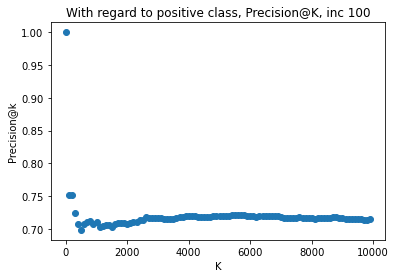

In [30]:
# plot scatterplot
plt.scatter(X_axis, y_axis)
plt.xlabel("K")
plt.ylabel("Precision@k")
plt.title("With regard to positive class, Precision@K, inc 100")
plt.show()

### 9. Our precision@K plot from Question 8 only measures precision with regard to the positive class. For this type of binary classification, we may be equally interested in the classifier’s accuracy for both the positive and negative classes. Recompute confidence scores for your classifier so that the ‘most confident’ predictions include either the most confident positive or the most confident negative predictions (i.e., probability closest to 1 or probability closest to zero). The precision@K now measures whether the classifier has the correct label (either ‘positive’ or ‘negative’) among the K most confident entries. Report this precision@K for K ∈ {1, 100, 10000} and include a plot as in Question 8.

In [45]:
# probability method
probs = model.predict_proba(X)
pos_probs = [p[1] for p in probs]
abs_pos_probs = [abs(p - 0.5) for p in pos_probs]

[0.4605432527607113,
 0.46723435155720827,
 0.4723487872186698,
 0.4727899741380273,
 0.5385333063027186,
 0.5017037894508095,
 0.47897074146206486,
 0.5127639928363613,
 0.4790590893272605,
 0.528842396320999]

In [41]:
TF_sortedscores = [x >= 0.0 for x in sortedscores] # T for positive or zero scores 
is_correct = [a == b for a,b in zip(TF_sortedscores,sortedlabels)] # is_correct labels for scores
abs_sortedscores = [abs(x) for x in sortedscores]
scoreslabels2 = list(zip(abs_sortedscores, is_correct)) # (positive score, is_correct)
scoreslabels2.sort(reverse = True) 

# labels are no longer the original y -label
# labels are now True if score and y matched, and False otherwise
# should be sorted by highest abs(score)
sortedlabels2 = [x[1] for x in scoreslabels2]

In [43]:
X_ax = [1, 100, 10000]

def get_precision2(lbl):
    
    y_ax = []
    
    for k in X_ax:
        
        # relevant terms are correctly labeled
        # now it's possible that negative, correctly labeled scores are included
        intersection = sum(lbl[:k])
        y_ax.append(intersection / k)
        
    return y_ax

y_ax = get_precision2(sortedlabels2)
print(y_ax)

[1.0, 0.75, 0.6208]


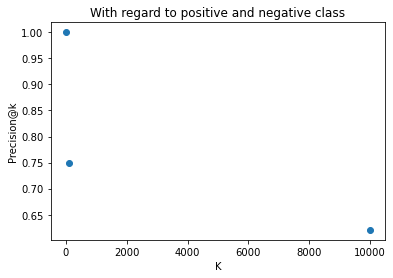

In [44]:
# plot scatterplot
plt.scatter(X_ax, y_ax)
plt.xlabel("K")
plt.ylabel("Precision@k")
plt.title("With regard to positive and negative class")
plt.show()

#### Precision@K for K = 1: 1.0
#### Precision@K for K = 100: 0.75
#### Precision@K for K = 10000: 0.6208